# Portfolio Analysis with Statistics

The method this notebook uses aims to maximize the excess expected return of a portfolio over its volatility. The model and its derivations are based on the approach of [Elton et al.](https://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.1976.tb03217.x) It is motivated by the single index model, which we will first cover. 

## Single Index Model

In short, the single index model(SIM) assumes that an asset's return is a dependent variable of the market's return, that is 

\begin{align}
R_i = \alpha_i + \beta_i R_m + \epsilon_i, \quad cov(R_m, \epsilon_i) = 0, \quad E(\epsilon_i\epsilon_j) = 0
\end{align}

where $R_i$ is the return of the $i^{th}$ asset, $R_m$ is the return of the market, and $\epsilon_i$ is random noise with mean $0$ and variance $\sigma_{\epsilon_i}^2$. The alpha of asset $i$, or $\alpha_i$ represents the "base" return of that asset (independent of the market) while the beta, or $\beta_i$, is the amount that asset changes for each unit of market change. Under this model, assets with positive betas follow the market, those with near-zero betas are largely unaffected by the market, and those with negative betas rise when the market falls. 

Additional notation includes variance of the return of a portfolio $\sigma_p^2$ and variance of the return of the market $\sigma_m^2$. Expected values will be represented by a bar, for instance, $\overline{R}_m$ is the expected return of the market.

## Finding an optimal portfolio(without short sales)

As stated before, this particular analysis aims to maximize the excess expected return of a portfolio over its volatility, or 

\begin{align}
\theta = \frac{\overline{R}_p - R_f}{\sigma_p^2}
\end{align}

$\overline{R}_p$ is the expected return of portfolio $p$, which can also be expressed as a weighted average of the expected returns of each asset in portfolio $p$, $\displaystyle\sum_{i=1}^{N} x_i\overline{R}_i$. Also, $R_f$ is a risk-free rate of return, such as the interest rate of a savings account. In other words, we want the portfolio with the maximal ratio of return (over a risk-free rate) to variance/volatility. Portfolios with very high risk will be penalized as well as portfolios with too low a rate of return despite stability. 

Before differentiating and solving, however, we need to impose two additional constraints. First, each asset weight $x_i$ must be larger than or equal to 0 because we are not allowing short selling. Second, the sum of weights must total to 1, as it would not make sense otherwise. Altogether, we have the following optimization problem:

\begin{align}
\text{max}& \quad \theta = \frac{\overline{R}_p - R_f}{\sigma_p^2} \\
\text{s.t.}& \quad \displaystyle\sum_{i=1}^{N} x_i = 1 \\
&\quad x_i \geq 0
\end{align}

Setting aside the constraints, we can rewrite $\theta$ in terms of $x_i$. First the numerator,
\begin{align}
\overline{R}_p - R_f &= \displaystyle\sum_{i=1}^{N} x_i \overline{R}_i - R_f \\
&= \sum_{i=1}^{N} x_i \overline{R}_i - \sum_{i=1}^{N} x_i R_f \\
&= \sum_{i=1}^{N} x_i (\overline{R}_i - R_f)
\end{align}

We can rewrite $\sigma_p^2$ by utilizing the historical covariances of the assets in the portfolio. Suppose $\sigma_i^2$ is the variance of the $i^{th}$ asset and $\sigma_{ij}$ is the covariance between the $i^{th}$ and $j^{th}$ assets. Then the variance of the portfolio is the weighted average of each $\sigma_i^2$ and $\sigma_{ij}$:
\begin{align}
\sigma_p^2 = \displaystyle\sum_{i=1}^N \sum_{j=1}^N x_i x_j \sigma_{ij} = \sum_{i=1}^N x_i^2 \sigma_i^2 + \sum_{i=1}^N \sum_{j=1, j\neq i}^N x_i x_j \sigma_{ij}
\end{align}

Using the SIM model, we also have the following:
\begin{align}
\sigma_i^2 = var(R_i) &= var(\alpha_i + \beta_i R_m + \epsilon_i) \\ 
&= var(\beta_i R_m) + var(\epsilon_i) + 2\beta_i cov(R_m, \epsilon_i) \\
&= \beta_i^2 \sigma_m^2 + \sigma_{\epsilon_i}^2 \\
\sigma_{ij} = cov(R_i, R_j) &= cov(\alpha_i + \beta_i R_m + \epsilon_i, \alpha_j + \beta_j R_m + \epsilon_j) \\
&= \beta_i \beta_j cov(R_m, R_m) + \beta_i cov(R_m, \epsilon_j) + \beta_j cov(R_m, \epsilon_i) + cov(\epsilon_i, \epsilon_j) \\
&= \beta_i \beta_j \sigma_m^2
\end{align}

Plugging these two results into our expression for $\sigma_p^2$, we get
\begin{align}
\sigma_p^2 &= \displaystyle \sum_{i=1}^N x_i^2 \beta_i^2 \sigma_m^2 + \sum_{i=1}^N x_i^2 \sigma_{\epsilon_i} + \sum_{i=1}^N \sum_{j=1,j\neq i}^N x_i x_j \beta_i \beta_j \sigma_m^2 \\
\implies \theta &= \frac{\displaystyle\sum_{i=1}^{N} x_i (\overline{R}_i - R_f)}{\sqrt{\displaystyle \sum_{i=1}^N x_i^2 \beta_i^2 \sigma_m^2 + \sum_{i=1}^N x_i^2 \sigma_{\epsilon_i} + \sum_{i=1}^N \sum_{j=1,j\neq i}^N x_i x_j \beta_i \beta_j \sigma_m^2}}
\end{align}

Moving onto the optimizing, we can also notice that $\theta$ is not only [homogenous](https://en.wikipedia.org/wiki/Homogeneous_function), but it is homogenous with degree 0. In other words, if we multiply each $x_i$ by a factor of $r$, this actually does not change the value of $\theta$. Thus we can safely ignore the equality constraint(but must still consider the inequality/nonnegative constraints), and our Lagrangian is 
\begin{align}
\mathcal{L} = \frac{\displaystyle\sum_{i=1}^{N} x_i (\overline{R}_i - R_f)}{\sigma_p} + \sum_{i=1}^N \mu_i x_i
\end{align}

Differentiating w.r.t $x_i$ and equating to zero(to avoid vector calculus), 
\begin{align}
\frac{\partial \mathcal{L}}{\partial x_i} &= \frac{(\overline{R}_i - R_f)\sigma_p - \frac{\partial \sigma_p}{\partial x_i} \cdot \displaystyle\sum_{i=1}^N x_i (R_i - R_f)}{\sigma_p^2} = \frac{\overline{R}_i - R_f}{\sigma_p} - \frac{\partial \sigma_p}{\partial x_i} \cdot \frac{\displaystyle\sum_{i=1}^N x_i (R_i - R_f)}{\sigma_p^2} + \mu_i\\
\frac{\partial \sigma_p}{\partial x_i} &= \frac{1}{2}\left(\displaystyle \sum_{i=1}^N x_i^2 \beta_i^2 \sigma_m^2 + \sum_{i=1}^N x_i^2 \sigma_{\epsilon_i} + \sum_{i=1}^N \sum_{j=1,j\neq i}^N x_i x_j \beta_i \beta_j \sigma_m^2\right)^{-\frac{1}{2}}\left(2x_i\beta_i^2 \sigma_m^2 + 2x_i \sigma_{\epsilon_i}^2 + 2\sum_{j=1,j\neq i}^N x_j \beta_i \beta_j \sigma_m^2\right) \\
&= \frac{x_i\beta_i^2 \sigma_m^2 + x_i \sigma_{\epsilon_i}^2 + \sum_{j=1,j\neq i}^N x_j \beta_i \beta_j \sigma_m^2}{\sigma_p} \\
\implies \frac{\partial \mathcal{L}}{\partial x_i} &= \frac{\overline{R}_i - R_f}{\sigma_p} - \frac{\displaystyle\sum_{i=1}^N x_i (R_i - R_f)}{\sigma_p^3} \left(x_i\beta_i^2 \sigma_m^2 + x_i \sigma_{\epsilon_i}^2 + \sum_{j=1,j\neq i}^N x_j \beta_i \beta_j \sigma_m^2\right) + \mu_i = 0 \\
\implies& \frac{\overline{R}_i - R_f}{\sigma_p} - \frac{\displaystyle\sum_{i=1}^N x_i (R_i - R_f)}{\sigma_p^2} \left(x_i\beta_i^2 \sigma_m^2 + x_i \sigma_{\epsilon_i}^2 + \sum_{j=1,j\neq i}^N x_j \beta_i \beta_j \sigma_m^2\right) + \mu_i = 0 \\
\end{align}

Now define $z_i = \frac{\overline{R}_i - R_f}{\sigma_p^2} x_i$. Solving the above expression for $z_i$(and leaving out boring algebra) yields 

\begin{align}
z_i = \frac{\overline{R}_i - R_f}{\sigma_{\epsilon_i}^2} - \frac{\beta_i}{\sigma_{\epsilon_i}^2} \sigma_m^2 \displaystyle\sum_{j=1}^N \beta_j z_j + \mu_i
\end{align}

with the KKT conditions $z_i \geq 0$, $\mu_i \geq 0$, $z_i \mu_i \geq 0$. Suppose we have already found the $k$ assets belonging in the optimal portfolio, and note that their corresponding $\mu_1, \ldots \mu_k = 0$ in order to minimize the Lagrangian. The assets that are not part of this optimal portfolio have negative $z_i$'s, thus it is also true that 
\begin{align}
\sum_{i=1}^N z_i \mu_i = \sum_{j=1}^k z_j \mu_j
\end{align}

Muliplying each $z_i$ by $\beta_i$ and summing from $1$ to $k$(or equivalently to $N$), we have
\begin{align}
&\sum_{i=1}^k z_i \beta_i = \sum_{i=1}^k \frac{\overline{R}_i - R_f}{\sigma_{\epsilon_i}} \beta_i - \sum_{i=1}^k \left(\frac{\beta_i}{\sigma_{\epsilon_i}} \sigma_m^2 \sum_{j=1}^k z_j \beta_j\right) \beta_i \\
\implies &\sum_{i=1}^k z_i \beta_i + \left(\sum_{i=1}^k \frac{\beta_i}{\sigma_{\epsilon_i}} \sigma_m^2\right)\left(\sum_{j=1}^k z_j \beta_j\right) = \sum_{i=1}^k \frac{\overline{R}_i - R_f}{\sigma_{\epsilon_i}} \beta_i \\
\implies &\displaystyle\sum_{i=1}^k z_i \beta_i = \frac{\displaystyle\sum_{i=1}^k \frac{\overline{R}_i - R_f}{\sigma_{\epsilon_i}} \beta_i}{1 + \sigma_m^2 \displaystyle\sum_{j=1}^k \frac{\beta_j}{\sigma_{\epsilon_j}}}
\end{align}

We can now rewrite the original $z_i$ equation 
\begin{align}
z_i &= \frac{\beta_i}{\sigma_{\epsilon_i}} \left(\frac{\overline{R}_i - R_f}{\beta_i} - \phi_k\right) + \mu_i
\end{align}

where $\phi_k = \sigma_m^2 \displaystyle\sum_{i=1}^k z_i \beta_i$. Regarding $\mu_i$, the KKT conditions imply that positive $z_i$ values will have zero $\mu_i$, and negative $z_i$ values will have zero $\mu_i$ as well.

Finding the assets that belong to the optimal portfolio is now relatively simple. We just need to calculate and rank each asset according to their excess return to beta ratio, or $\frac{\overline{R}_i - R_f}{\beta_i}$, and weed out those that have ratios less than $\phi_k$. The positive $z_i$'s can then be normalized by dividing by their sum total, yielding the weights of each asset to be included. 

## Data ETL

To access stock data, we will use the [yfinance library](https://github.com/ranaroussi/yfinance) (one could also scrape prices from a webpage, though formatting may differ). We first download the historical monthly stock prices for the chosen stocks/tickers(slightly modifying the code in the library tutorial). The data comes in the form of a pandas dataframe with multi-level headers, so we also unstack the levels for simpler access.

In [1]:
import yfinance as yf
import numpy as np
import scipy.stats as stats
import pandas as pd

In [3]:
ticks = ["AMD", "MSFT", "TSLA"]
data = yf.download(tickers = ['^GSPC'] + ticks, start = '2016-06-01', period = '1mo', interval = '1mo', group_by = 'ticker', auto_adjust = True, prepost = False, threads = True, proxy = None)

[*********************100%***********************]  4 of 4 completed


In [4]:
# unstack
stocks_raw = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
stocks_raw = stocks_raw.groupby('Ticker').filter(lambda x: len(x) > 36)
stocks_raw = stocks_raw.sort_values(by=['Date', 'Ticker'])
stocks_raw

,Ticker,Close,High,Low,Open,Volume
Date,,,,,,
2016-06-01,AMD,5.140000,5.520000,4.070000,4.600000,6.256425e+08
2016-06-01,MSFT,47.140781,48.780623,44.257246,48.310780,8.236270e+08
2016-06-01,TSLA,42.456001,48.169998,37.574001,44.296001,6.083640e+08
2016-06-01,^GSPC,2098.860107,2120.550049,1991.680054,2093.939941,8.685270e+10
2016-07-01,AMD,6.860000,7.160000,4.820000,5.090000,7.005624e+08
...,...,...,...,...,...,...
2021-07-01,^GSPC,4327.160156,4393.680176,4289.370117,4300.729980,3.427683e+10
2021-07-19,AMD,86.580002,87.229401,84.239998,84.989998,3.890735e+07
2021-07-19,MSFT,277.010010,280.369995,275.000000,278.933502,3.105582e+07


Since we only want one stock price per month, we filter out the last row of each asset if it does not fall on the first day of the month. We also only keep the last 5 years of data to maintain an accurate representation of each company's relevant returns(profitability in the 1990s does not entail profitability in 2020s). Because we require the previous month's price to compute the current month's return, we need to keep an extra month(a total of 61 months)

In [5]:
recent = stocks_raw.index[-1] - pd.DateOffset(day = 1)
stocks = stocks_raw.loc[stocks_raw.index <= recent].copy()
#sp500 = sp500_raw.loc[(sp500_raw.index <= recent) & (sp500_raw.index >= begin)].copy()

To compute the (percent) return of a specified observation, we subtract the current price with last month's price and divide by last month's price. We can easily vectorize this by subtracting an array of the (open) prices without the last observation from an array of the (open) prices without the first observation. We then divide by the former.  

To make calculating parameters easier, we can pivot the dataframe such that each ticker's percent returns form individual columns. Note that we need to mask the data matrix to ignore NaN values. 

In [6]:
pivoted = stocks.pivot(columns = 'Ticker', values = 'Open').dropna(axis=1, how='all')
spprices = pivoted['^GSPC'].to_numpy()
pivoted = pivoted.drop(columns = ['^GSPC'])
prices = pivoted.to_numpy()
returnarr = prices[1:, :] - prices[:(prices.shape[0] - 1), :]
returnarr = returnarr /  prices[:(prices.shape[0] - 1), :]
spreturns = (spprices[1:] - spprices[:(len(spprices) - 1)]) / spprices[:(len(spprices) - 1)]

## SIM and weight calculations

Next we compute the single index model parameters and store them in a dataframe, which includes C values. Finally we determine the assets above the cutoff point and compute the portfolio weights. 

In [7]:
betas = np.zeros(returnarr.shape[1])
alphas = np.zeros(returnarr.shape[1])
unsyserr = np.zeros(returnarr.shape[1])
for i in np.arange(returnarr.shape[1]):
    treturn = returnarr[:,i]
    tnonan = treturn[np.logical_not(np.isnan(treturn))]
    spmatch = spreturns[(len(spreturns) - len(tnonan)):]
    try:
        betas[i], alphas[i], r, p, se = stats.linregress(spmatch, tnonan)
    except: 
        print(returnarr[:,i])
    unsyserr[i] = np.sum((tnonan - alphas[i] - betas[i]*spmatch)**2) / (len(spmatch) - 2)

In [8]:
returnmean = returnarr.mean(axis = 0)
simdf = pd.DataFrame(data = {'alpha': alphas, 'beta': betas, 'eps': unsyserr, 'rmean': returnmean}, index = pivoted.columns.values)
simdf['excess'] = simdf['rmean'] / simdf['beta']
simdf = simdf.sort_values(by=['excess'], ascending = False)
simdf = simdf.loc[(simdf['excess'] > 0) & (simdf['beta'] > 0)]

In [9]:
simdf

,alpha,beta,eps,rmean,excess
MSFT,0.019324,0.808193,0.001110,0.029830,0.036909
AMD,0.038237,1.940392,0.019174,0.063460,0.032705
TSLA,0.035041,2.100616,0.029258,0.062347,0.029680


In [10]:
num = simdf['rmean'] * simdf['beta'] / simdf['eps']
den = simdf['beta']**2 / simdf['eps']
simdf['C'] = spreturns.var() * num.cumsum() / (1 + spreturns.var() * den.cumsum())

In [11]:
cutoff = simdf.loc[simdf['C'] < simdf['excess']]
z = (cutoff['beta'] / cutoff['eps']) * (cutoff['excess'] - cutoff['C'])
weights = z.sort_values(ascending = False) / z.sum()
weights.head()

MSFT    0.889661
AMD     0.076655
TSLA    0.033683
dtype: float64

## Portfolio Details

We can plot the price data of assets included in the portfolio for a bit of insight on why they were chosen.

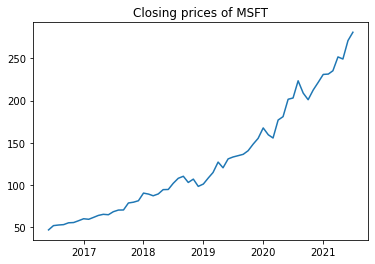

In [15]:
import matplotlib.pyplot as plt
plt.plot(stocks.loc[stocks['Ticker'] == weights.index[0], 'Close'])
plt.title("Closing prices of " + weights.index[0])
plt.show()

We can also compare the performance of the portfolio to the market (in this case the S&P500).

In [20]:
date1 = stocks.loc[(stocks.index == '2021-05-01') & (stocks['Ticker'] != '^GSPC')].set_index('Ticker', drop=True)
date1 = date1.loc[weights.index.values, 'Close']
date2 = stocks.loc[(stocks.index == '2021-07-01') & (stocks['Ticker'] != '^GSPC')].set_index('Ticker', drop=True)
date2 = date2.loc[weights.index.values, 'Close']
percchange = (date2 - date1) / date1
sum(percchange * weights)

0.11960394505491298

In [23]:
spdate1 = stocks.loc[(stocks.index == '2021-05-01') & (stocks['Ticker'] == '^GSPC')]['Close'].values
spdate2 = stocks.loc[(stocks.index == '2021-07-01') & (stocks['Ticker'] == '^GSPC')]['Close'].values
(spdate2 - spdate1) / spdate1

array([0.02926905])

We can also translate the weights of each asset to the approximate number of shares by pulling the opening prices of that day.

In [16]:
from datetime import datetime
today_date = datetime.today().strftime('%Y-%m-%d')
latest_raw = yf.download(tickers = weights.index.values.tolist(), start = today_date, period = '1d', interval = '1d', group_by = 'ticker', auto_adjust = True, prepost = False, threads = True, proxy = None)
latest = latest_raw.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

[*********************100%***********************]  3 of 3 completed


In [18]:
latest_prices = latest.set_index('Ticker', drop=True).loc[weights.index.values, 'Close']
portvalue = 10000
numstocks = portvalue*weights/latest_prices
numstocks

MSFT    32.116574
AMD      8.853694
TSLA     0.521238
dtype: float64